In [1]:
from mmf.models.mmbt import MMBT
from mmf.models.visual_bert import VisualBERT
from mmf.models.unimodal import UnimodalText

In [53]:
class debug:
    def __enter__(self):
        import pdb; pdb.set_trace()
    def __exit__(self, *args, **kwargs):
        pass

In [39]:
# get model
#model = VisualBERT.from_pretrained('visual_bert.finetuned.hateful_memes.from_coco')
model = UnimodalText.from_pretrained('unimodal_text.hateful_memes.bert')
model.cuda()

Missing keys ['base.encoder.embeddings.position_ids'] in the checkpoint.
If this is not your checkpoint, please open up an issue on MMF GitHub. 
Unexpected keys if any: []


UnimodalText(
  (base): UnimodalBase(
    (encoder): BertModelJit(
      (embeddings): BertEmbeddingsJit(
        (word_embeddings): Embedding(30522, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoderJit(
        (layer): ModuleList(
          (0): BertLayerJit(
            (attention): BertAttentionJit(
              (self): BertSelfAttentionJit(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=768, out_features=768, bias=T

In [10]:
# get config
from argparse import Namespace
from mmf.utils.configuration import Configuration
from mmf.utils.distributed import infer_init_method
from mmf.datasets.builders.hateful_memes.builder import HatefulMemesBuilder
options = ["env.save_dir=/home/jupyter/save",
           "env.data_dir=/home/jupyter/.cache/torch/mmf/data",
           "dataset=hateful_memes",
           "run_type=val"]

model_type = 'vb-direct'

if model_type == 'vb-coco':
    options += ["config=/home/isaacrehg/mmf/projects/hateful_memes/configs/visual_bert/defaults.yaml",
           "model=visual_bert",
           "checkpoint.resume_zoo=visual_bert.finetuned.hateful_memes.from_coco"]# coco-ft

elif model_type == 'vb-direct':
    options += ["config=/home/isaacrehg/mmf/projects/hateful_memes/configs/visual_bert/defaults.yaml",
           "model=visual_bert",
           "checkpoint.resume_zoo=visual_bert.finetuned.hateful_memes.direct"] # separate-ft

else:
    options += ["config=/home/isaacrehg/mmf/projects/hateful_memes/configs/unimodal/bert.yaml",
           "model=unimodal_text",
           "checkpoint.resume_zoo=unimodal_text.hateful_memes.bert",
          ]#"checkpoint.resume_pretrained=False"]
    
#with debug():
args = Namespace(config_override=None)
args.opts = options
config_ = Configuration(args)
config_.args = args
config = config_.get_config()
config.start_rank = 0
if config.distributed_init_method is None:
    infer_init_method(config)
config.device_id = 0

In [ ]:
# test loaded model
from mmf_cli.run import run
with debug():
    run(predict=True, opts=options)

In [ ]:
# model.model.bert.embeddings.word_embeddings.weight[0,:10]
[ 0.0028, -0.0529, -0.0445, -0.0429, -0.0448, -0.0287, -0.0111,
 -0.0214, -0.0219, -0.0755]
# model.model.bert.embeddings.projection.weight[0,:10]
[ 0.0197,  0.0086, -0.0135,  0.0146,  0.0216, -0.0082, -0.0100,
 0.0407, 0.0282,  0.0425]
# model.model.classifier[1].weight[0, :10]
[ 0.0261, -0.0210,  0.0094, -0.0097,  0.0126,  0.0288, -0.0114,
 0.0180, -0.0253,  0.0077]

In [ ]:
config__

In [ ]:
# we have initialize an trainer just to setup the model properly (thanks facebook *sarcasm*)
from mmf.utils.env import set_seed, setup_imports
from mmf.common.registry import registry
from mmf.utils.build import build_config, build_trainer
#config.import_user_dir()
config__ = config_.get_config()
seed = config__.training.seed
config__.training.seed = set_seed(seed if seed == -1 else seed)
registry.register('seed', config__.training.seed)
config__ = build_config(config_)
trainer = build_trainer(config__)
trainer.load()

In [ ]:
model = trainer.model
model.cuda()
del trainer

In [ ]:
import omegaconf
from mmf.utils.build import build_model
attributes = config.model_config[config.model]
with omegaconf.open_dict(attributes):
    attributes.model = config.model
model = build_model(attributes)
model.cuda()

In [ ]:
model

In [ ]:
model.model.bert.embeddings.word_embeddings.weight[0,:10]

In [ ]:
model.model.bert.embedding.word_embedding.weight[0,:10]

In [11]:
# get dataloader
import torch
from mmf.common.dataset_loader import DatasetLoader
from mmf.common.batch_collator import BatchCollator
#with debug():
dataloader = DatasetLoader(config)
dataloader.load_datasets()
dataset_instance = dataloader.val_dataset._datasets[0]
val_loader = loader = torch.utils.data.DataLoader(
        dataset=dataset_instance,
        pin_memory=True,
        collate_fn=BatchCollator(
            dataset_instance.dataset_name, dataset_instance.dataset_type
        ),
        num_workers=4,
        drop_last=False,  # see also MultiDatasetLoader.__len__
        batch_size=16,
        shuffle=False
    )

In [12]:
prep = dataloader.prepare_batch(next(iter(val_loader)))

In [ ]:
def save_out(m, inp, out):
    m.output = out
hook = model.model.bert.encoder.register_forward_hook(save_out)

In [ ]:
prep.keys()

In [18]:
# for use with unimodal_text bert
from mmf.common.sample import to_device
device = next(model.parameters()).device
sample_list = prep
sample_list = to_device(sample_list, device)

input_ids = sample_list.input_ids
attention_mask = sample_list.input_mask
token_type_ids = sample_list.segment_ids
position_ids = None
input_embeds = None

# pre-encoder forward of model.base.encoder
input_shape = input_ids.size()
if attention_mask is None:
    attention_mask = torch.ones(input_shape, device=device)
if token_type_ids is None:
    token_type_ids = torch.zeros(input_shape, dtype=torch.long, device=device)
if attention_mask.dim() == 3:
    extended_attention_mask = attention_mask[:, None, :, :]
elif attention_mask.dim() == 2:
    # Provided a padding mask of dimensions [batch_size, seq_length]
    # - if the model is a decoder, apply a causal mask in addition to
    # the padding mask
    # - if the model is an encoder, make the mask broadcastable to
    # [batch_size, num_heads, seq_length, seq_length]
    extended_attention_mask = attention_mask[:, None, None, :]
else:
    raise ValueError(
        f"Wrong shape for input_ids (shape {input_shape}) or "
        + f"attention_mask (shape {attention_mask.shape})"
    )
extended_attention_mask = extended_attention_mask.to(
    dtype=next(model.base.encoder.parameters()).dtype
)  # fp16 compatibility
extended_attention_mask = (1.0 - extended_attention_mask) * -10000.0
encoder_extended_attention_mask = None

embedding_output = model.base.encoder.embeddings(
    input_ids=input_ids,
    position_ids=position_ids,
    token_type_ids=token_type_ids,
    inputs_embeds=None,
)


encoded_layers = model.base.encoder.encoder(
    embedding_output,
    attention_mask=extended_attention_mask,
    encoder_hidden_states=None,
    encoder_attention_mask=None,
    output_attentions=True
)

In [32]:
# finish model.base.encoder forward
sequence_output = encoded_layers[0]
pooled_output = model.base.encoder.pooler(sequence_output)

# finish model.base forward
x = torch.flatten(pooled_output, start_dim=1)

# finish model forward
logits = model.classifier(x)

In [ ]:
# for use with visual bert
import torch
from mmf.common.sample import to_device
from mmf.utils.torchscript import getattr_torchscriptable
device = next(model.parameters()).device
sample_list = prep
sample_list = to_device(sample_list, device)
sample_list = model.update_sample_list_based_on_head(sample_list)
sample_list = model.add_custom_params(sample_list)
sample_list = model.flatten_for_bert(sample_list)
sample_list = model.add_post_flatten_params(sample_list)

# inputs to model.model:
#sample_list["input_ids"],
#--> 565             sample_list["input_mask"],
#    566             sample_list["attention_mask"],
#    567             sample_list["token_type_ids"],
#sample_list["visual_embeddings"],
#--> 569             sample_list["visual_embeddings_type"],
#    570             getattr_torchscriptable(sample_list, "image_text_alignment", None),
#    571             getattr_torchscriptable(sample_list, "masked_lm_labels", None),
    
# inputs to model.model.bert:
input_ids = sample_list["input_ids"]
attn_mask = sample_list["attention_mask"]
token_type = sample_list["token_type_ids"]
vis_embed = sample_list["visual_embeddings"]
vis_embed_type = sample_list["visual_embeddings_type"]
img_text_alignment = getattr_torchscriptable(sample_list, "image_text_alignment", None)

# get embeddings
if attn_mask is None:
    attn_mask = torch.ones_like(input_ids)
if token_type is None:
    token_type = torch.zeros_like(input_ids)
extended_attention_mask = attn_mask.unsqueeze(1).unsqueeze(2)
extended_attention_mask = extended_attention_mask.to(
    dtype=next(model.model.bert.parameters()).dtype
)  # fp16 compatibility
extended_attention_mask = (1.0 - extended_attention_mask) * -10000.0

with torch.no_grad():
    embedding_output = model.model.bert.embeddings(
        input_ids,
        token_type,
        visual_embeddings=vis_embed,
        visual_embeddings_type=vis_embed_type, 
        image_text_alignment=img_text_alignment,
    )

    encoded_layers = model.model.bert.encoder(embedding_output, extended_attention_mask, output_attentions=True)

In [19]:
attns = []
attn = encoded_layers[1]
attns += [torch.stack([a.data.cpu() for a in attn], dim=1)]
import numpy as np
np.save('save/attn_weights/test_attn-unimodal_bert.npy', torch.cat(attns).cpu().numpy())

In [ ]:
# completion of model.model.bert forward
sequence_output = encoded_layers[0]
pooled_output = model.model.bert.pooler(sequence_output)

In [ ]:
# completion of model.model forward
attention_weights = []

pooled_output = model.model.dropout(pooled_output)
logits = model.model.classifier(pooled_output)
logits = logits.contiguous().view(-1, model.model.num_labels)

In [ ]:
loss_fn = torch.nn.CrossEntropyLoss()
print(loss_fn(logits, prep['targets']).item())

print((logits.argmax(dim=1) == prep['targets']).sum().item() / len(prep['targets']))

### Gather data for cross-modal attention by loss improvement correlation

In [47]:
np.zeros((2,5)).astype(np.bool)

array([[False, False, False, False, False],
       [False, False, False, False, False]])

In [49]:
a = np.ndarray((2, 5, 3))
a[np.zeros((2, 5)).astype(np.bool)]

array([], shape=(0, 3), dtype=float64)

In [5]:
def compute_entropy(attn, seq_lens=None):
    # attn: [batch X layers X heads X seq_len X seq_len]
    assert seq_lens is not None
    
    # get valid mask [batch X seq_len]
    valid_mask = np.arange(attn.shape[-1])[None].repeat(attn.shape[0],
                                                        axis=0)
    valid_mask = np.logical_or(valid_mask < np.array(seq_lens)[:,None],
                              valid_mask >= 128)
    
    # get entropy  
    entropy = attn * torch.log(attn) # [batch X layers X heads X 128 X 128]
    entropy = entropy.cpu().numpy()
    entropy = entropy.transpose(0, 3, 1, 2, 4) # [batch X 128(0) X layers X heads X 128(1)]
    entropy[~valid_mask] = 0
    entropy = entropy.transpose(0, 4, 2, 3, 1) # [batch X 128(1) X layers X heads X 128(0)]
    entropy[~valid_mask] = 0
    entropy = entropy.transpose(0, 2, 3, 4, 1) # [batch X layer X, heads X 128(0) X 128(1)]
    entropy = entropy.sum(axis=4) # [batch X layers X heads X 128]

    # average [batch X layers]
    avg_ent = entropy.sum(axis=2).sum(axis=2) / np.array(seq_lens)[:,None]
    
    return avg_ent

def compute_attn_alloc(attn, seq_lens=None):
    # attn: [batch X layers X heads X seq_len(0) X seq_len(1)]
    assert seq_lens is not None
    
    # get valid mask [batch X seq_len]
    range_arr = np.arange(attn.shape[-1])[None].repeat(attn.shape[0],
                                                        axis=0)
    text_mask = range_arr < np.array(seq_lens)[:,None]
    vis_mask = range_arr >= 128
    valid_mask = np.logical_or(text_mask,
                              vis_mask)
        
    attn = attn.cpu().numpy()
        
    attn = attn.transpose(0, 3, 1, 2, 4) # [batch X 128(0) X layers X heads X 128(1)]
    attn_ = attn.copy()
    
    ##### COMPUTE WITHIN TEXT and VIS MASS ##
    
    #attn_t2t = attn_.copy()
    
    ##### COMPUTE TEXT and VIS MASS #####
    
    attn[~valid_mask] = 0
    attn = attn.transpose(0, 4, 2, 3, 1) # [batch X 128(1) X layers X heads X 128(0)]
    
    attn_text, attn_vis = attn.copy(), attn.copy()
    attn_text[~text_mask] = 0
    attn_vis[~vis_mask] = 0
    attn_text = attn_text.transpose(0, 2, 3, 4, 1) # [batch X layer X, heads X 128(0) X 128(1)]
    attn_vis = attn_vis.transpose(0, 2, 3, 4, 1) # [batch X layer X, heads X 128(0) X 128(1)]
    #attn = attn.transpose(0, 2, 3, 4, 1) # [batch X layer X, heads X 128(0) X 128(1)]
        
    text_mass = attn_text.sum(axis=(3, 4)).mean(axis=2)
    vis_mass = attn_vis.sum(axis=(3, 4)).mean(axis=2)
    
    ##### COMPUTE CROSS MODAL MASS #####
    
    attn_t2v = attn_.copy()  # [batch X 128(1) X layers X heads X 128(0)]
    attn_v2t = attn_.copy()
    
    attn_t2v[~text_mask] = 0
    attn_v2t[~vis_mask] = 0
    
    attn_t2v = attn_t2v.transpose(0, 4, 2, 3, 1) # [batch X 128(1) X layers X heads X 128(0)]
    attn_v2t = attn_v2t.transpose(0, 4, 2, 3, 1) # [batch X 128(1) X layers X heads X 128(0)]
    
    attn_t2v[~vis_mask] = 0
    attn_v2t[~text_mask] = 0
    
    attn_t2v = attn_t2v.transpose(0, 2, 3, 4, 1) # [batch X layer X, heads X 128(0) X 128(1)]
    attn_v2t = attn_v2t.transpose(0, 2, 3, 4, 1) # [batch X layer X, heads X 128(0) X 128(1)]
    
    t2v_mass = attn_t2v.sum(axis=(3, 4)).mean(axis=2)
    v2t_mass = attn_v2t.sum(axis=(3, 4)).mean(axis=2)
    
    return text_mass, vis_mass, (t2v_mass, v2t_mass)
    

In [171]:
z.allow_pickle = True
seq_lens = [len(text) for text in z['text']]
attn = old
range_arr = np.arange(attn.shape[-1])[None].repeat(attn.shape[0],
                                                        axis=0)
text_mask = range_arr < np.array(seq_lens)[:,None]
vis_mask = range_arr >= 128
valid_mask = np.logical_or(text_mask,
                          vis_mask)

In [172]:
attn = attn.transpose(0, 3, 1, 2, 4) # [batch X 128(0) X layers X heads X 128(1)]
attn_ = attn.copy()
attn[~valid_mask] = 0

In [173]:
attn = attn.transpose(0, 4, 2, 3, 1) # [batch X 128(1) X layers X heads X 128(0)]

In [177]:
_attn = attn[0].copy()
_attn[~text_mask[0]] = 0

In [184]:
_attn[0, 0, 0, :]

array([0.06306862, 0.06291715, 0.09523566, 0.05605834, 0.03624731,
       0.07269235, 0.0168991 , 0.06116404, 0.05209135, 0.10181452,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

19.106676

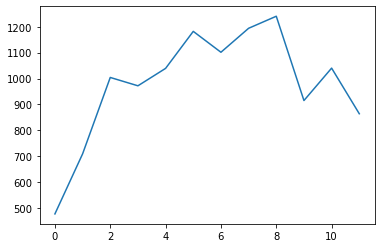

In [179]:
plt.plot(range(12), _attn.sum(axis=(0, 2, 3)))

In [92]:
sample_list['id']

tensor([ 5439, 34528, 93541, 16704, 48792,  7528,  1268, 83675, 37198, 48670,
         9863, 97320], device='cuda:0', dtype=torch.int32)

In [42]:
sample_list['id']

tensor([ 5439, 34528, 93541, 16704, 48792,  7528,  1268, 83675, 37198, 48670,
         9863, 97320], device='cuda:0', dtype=torch.int32)

In [23]:
text_attn_mass[3]

array([16.714607, 26.432411, 60.94254 , 55.181274, 58.04466 , 72.923134,
       74.01934 , 52.482365, 79.57023 , 70.668594, 80.09521 , 77.477325],
      dtype=float32)

In [37]:
# VISUAL BERT
import numpy as np
import torch
from mmf.common.sample import to_device
from mmf.utils.torchscript import getattr_torchscriptable
from tqdm.auto import tqdm
device = next(model.parameters()).device

output_attn = True

ncorrect = total = 0
avg_ents = []
s_correct = []
text_lengths = []
text_attn_mass = []
vis_attn_mass = []
t2v_attn_mass = []
v2t_attn_mass = []


stats = ['attn_alloc', 'entropy']

with torch.no_grad():
    for x in tqdm(val_loader):
        prep = dataloader.prepare_batch(x)
        sample_list = prep
        sample_list = to_device(sample_list, device)
        sample_list = model.update_sample_list_based_on_head(sample_list)
        sample_list = model.add_custom_params(sample_list)
        sample_list = model.flatten_for_bert(sample_list)
        sample_list = model.add_post_flatten_params(sample_list)

        # inputs to model.model.bert:
        input_ids = sample_list["input_ids"]
        attn_mask = sample_list["attention_mask"]
        token_type = sample_list["token_type_ids"]
        vis_embed = sample_list["visual_embeddings"]
        vis_embed_type = sample_list["visual_embeddings_type"]
        img_text_alignment = getattr_torchscriptable(sample_list, "image_text_alignment", None)

        # get embeddings
        if attn_mask is None:
            attn_mask = torch.ones_like(input_ids)
        if token_type is None:
            token_type = torch.zeros_like(input_ids)
        extended_attention_mask = attn_mask.unsqueeze(1).unsqueeze(2)
        extended_attention_mask = extended_attention_mask.to(
            dtype=next(model.model.bert.parameters()).dtype
        )  # fp16 compatibility
        extended_attention_mask = (1.0 - extended_attention_mask) * -10000.0

        embedding_output = model.model.bert.embeddings(
            input_ids,
            token_type,
            visual_embeddings=vis_embed,
            visual_embeddings_type=vis_embed_type, 
            image_text_alignment=img_text_alignment,
        )

        encoded_layers = model.model.bert.encoder(embedding_output, extended_attention_mask,
                                                  output_attentions=output_attn)
        
        seq_lens = [len(text) for text in sample_list['text']]
        if output_attn:
             # compute statistics [batch X layers X heads X 128 X 128]
            attn = torch.stack(encoded_layers[1], dim=1)
                       
            if 'entropy' in stats:
                avg_ents += [compute_entropy(attn, seq_lens=seq_lens)]
            if 'attn_alloc' in stats:
                text_attn, vis_attn, cross_attn = compute_attn_alloc(attn, seq_lens=seq_lens)
                t2v_attn, v2t_attn = cross_attn
                text_attn_mass += [text_attn]
                vis_attn_mass += [vis_attn]
                t2v_attn_mass += [t2v_attn]
                v2t_attn_mass += [v2t_attn]
        
        # completion of model.model.bert forward
        sequence_output = encoded_layers[0]
        pooled_output = model.model.bert.pooler(sequence_output)
        
        # completion of model.model forward
        attention_weights = []

        pooled_output = model.model.dropout(pooled_output)
        logits = model.model.classifier(pooled_output)
        logits = logits.contiguous().view(-1, model.model.num_labels)

        
        preds = logits.argmax(dim=1)
        correct = preds == sample_list['targets']
        
        s_correct += [correct]
        text_lengths += [np.array(seq_lens)]
        
        ncorrect += correct.sum().item()
        total += len(sample_list['targets'])
        
ncorrect / total

0.6703703703703704

In [38]:
np.savez('/home/jupyter/save/attn_weights/visual_bert_coco-all_stats.npz',
        lengths=np.concatenate(text_lengths),
        correct=torch.cat(s_correct).cpu().numpy(),
        entropy=np.concatenate(avg_ents),
        text_mass=np.concatenate(text_attn_mass),
        vis_mass=np.concatenate(vis_attn_mass),
        t2v_mass=np.concatenate(t2v_attn_mass),
        v2t_mass=np.concatenate(v2t_attn_mass))

In [35]:
np.concatenate(avg_ents)

array([-400.5383113 , -431.56944862, -395.32534555, -360.25833834,
       -259.70224234, -112.57580566, -125.45141602, -145.82744892,
       -165.72941707, -174.01797251, -152.45526593, -231.44506836])

In [40]:
# UNIMODAL BERT

import torch
from mmf.common.sample import to_device
from mmf.utils.torchscript import getattr_torchscriptable
from tqdm.auto import tqdm
device = next(model.parameters()).device

output_attn = True

ncorrect = total = 0
avg_ents = []
s_correct = []
text_lengths = []
text_attn_mass = []
vis_attn_mass = []
t2v_attn_mass = []
v2t_attn_mass = []

stats = ['entropy']

with torch.no_grad():
    for x in tqdm(val_loader):
        prep = dataloader.prepare_batch(x)
        sample_list = prep

        sample_list = to_device(sample_list, device)

        input_ids = sample_list.input_ids
        attention_mask = sample_list.input_mask
        token_type_ids = sample_list.segment_ids
        position_ids = None
        input_embeds = None

        # pre-encoder forward of model.base.encoder
        input_shape = input_ids.size()
        if attention_mask is None:
            attention_mask = torch.ones(input_shape, device=device)
        if token_type_ids is None:
            token_type_ids = torch.zeros(input_shape, dtype=torch.long, device=device)
        if attention_mask.dim() == 3:
            extended_attention_mask = attention_mask[:, None, :, :]
        elif attention_mask.dim() == 2:
            # Provided a padding mask of dimensions [batch_size, seq_length]
            # - if the model is a decoder, apply a causal mask in addition to
            # the padding mask
            # - if the model is an encoder, make the mask broadcastable to
            # [batch_size, num_heads, seq_length, seq_length]
            extended_attention_mask = attention_mask[:, None, None, :]
        else:
            raise ValueError(
                f"Wrong shape for input_ids (shape {input_shape}) or "
                + f"attention_mask (shape {attention_mask.shape})"
            )
        extended_attention_mask = extended_attention_mask.to(
            dtype=next(model.base.encoder.parameters()).dtype
        )  # fp16 compatibility
        extended_attention_mask = (1.0 - extended_attention_mask) * -10000.0
        encoder_extended_attention_mask = None

        embedding_output = model.base.encoder.embeddings(
            input_ids=input_ids,
            position_ids=position_ids,
            token_type_ids=token_type_ids,
            inputs_embeds=None,
        )


        encoded_layers = model.base.encoder.encoder(
            embedding_output,
            attention_mask=extended_attention_mask,
            encoder_hidden_states=None,
            encoder_attention_mask=None,
            output_attentions=True
        )
        
        seq_lens = [len(text) for text in sample_list['text']]
        if output_attn:
            # compute statistics [batch X layers X heads X 128 X 128]
            attn = torch.stack(encoded_layers[1], dim=1)            

            if 'entropy' in stats:
                avg_ents += [compute_entropy(attn, seq_lens=seq_lens)]
            if 'attn_alloc' in stats:
                text_attn, vis_attn, cross_attn = compute_attn_alloc(attn, seq_lens=seq_lens)
                t2v_attn, v2t_attn = cross_attn
                text_attn_mass += [text_attn]
                vis_attn_mass += [vis_attn]
                t2v_attn_mass += [t2v_attn]
                v2t_attn_mass += [v2t_attn]
        
        # finish model.base.encoder forward
        sequence_output = encoded_layers[0]
        pooled_output = model.base.encoder.pooler(sequence_output)

        # finish model.base forward
        x = torch.flatten(pooled_output, start_dim=1)

        # finish model forward
        logits = model.classifier(x)
        
        preds = logits.argmax(dim=1)
        correct = preds == sample_list['targets']
        
        s_correct += [correct]
        text_lengths += [np.array(seq_lens)]
        
        ncorrect += correct.sum().item()
        total += len(sample_list['targets'])
        
ncorrect / total

0.6166666666666667

In [41]:
np.savez('/home/jupyter/save/attn_weights/unimodal_bert-all_stats.npz',
        lengths=np.concatenate(text_lengths),
        correct=torch.cat(s_correct).cpu().numpy(),
        entropy=np.concatenate(avg_ents))

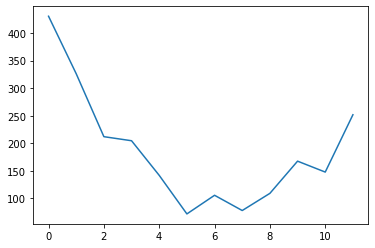

In [97]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(range(12), avg_e.mean(axis=0))

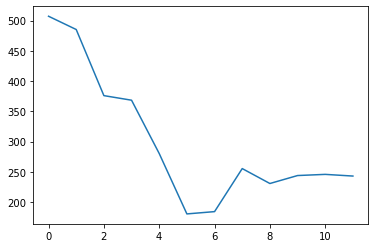

In [91]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(range(12), avg_e.mean(axis=0))

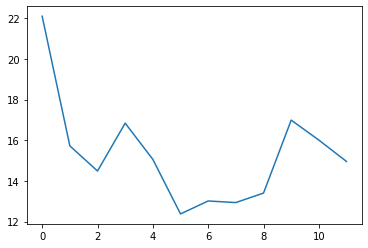

In [85]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(range(12), avg_e.mean(axis=0))

In [95]:
avg_e = -np.concatenate(avg_ents, axis=0)

### Save statistics

In [96]:
np.save('/home/jupyter/save/attn_weights/average_entropy-visual_bert_coco.npy',
       -np.concatenate(avg_ents, axis=0))

In [111]:
np.save('/home/jupyter/save/attn_weights/correct-unimodal_bert.npy',
       torch.cat(s_correct).cpu().numpy())

In [ ]:
prep.keys()

In [20]:
np.savez('/home/jupyter/save/attn_weights/batch_data.npz', **to_device(prep, 'cpu'))

In [129]:
z = np.load('/home/jupyter/save/attn_weights/batch_data.npz')

In [ ]:
z.allow_pickle = True
z['image_info_0'].item()['num_boxes']

In [126]:
old = np.load('save/attn_weights/test_attn-visual_bert_coco_ft.npy')

In [ ]:
old[0, 0, 0, 0, :10]

In [ ]:
attns[0][0, 0,0 ,0, :10]

In [ ]:
import torch
with torch.no_grad():
    with debug():
        out = model(prep)

In [ ]:
sample_list['attention_mask']

In [ ]:
model.model.bert.encoder.output[1]

In [ ]:
x, y, z = model.model.bert.output

In [ ]:
torch.jit.is_scripting()

In [ ]:
torch.jit._enabled = False

In [ ]:
y.shape

In [ ]:
config.env

In [ ]:
config.model_config.visual_bert.output_attentions

In [ ]:
!ls /home/jupyter/.cache/torch/mmf/data/datasets/hateful_memes/defaults

In [ ]:
!ls /home/isaacrehg/data/img